## Linear regression on a simulated concert dataset to predict concert ticket prices 

### Import necessary libraries and establish DB connection

In [65]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [66]:
db_path = 'concerts.db'
conn = sqlite3.connect(db_path)

### Query data from DB with SQL

1) Create a dictionary with appropriate column names and data queried from corresponding tables of the database

2) Initialise a pandas dataframe which we later populate with data from the dictionary

In [67]:
db_table_names = ('artist', 'customer', 'genre', 'performance', 'ticket', 'ticketpricing')
table_df_dict = dict()

for table_name in db_table_names:
    table_df_dict[table_name] = pd.read_sql_query(f'SELECT * FROM {table_name}', conn)

In [68]:
df = pd.DataFrame()

### Populate the DataFrame with data from the dictionary

1) *populate_with_data()* - implementation involves merging data from different tables of the database (smaller DFs - values of the dictionary) based on the id of other columns
2) split the df into X for features and y for label

In [69]:
def populate_with_data(df):
    df['Ticket Price'] = table_df_dict['ticket']['ticketPrice']
    df['Ticket Category'] = table_df_dict['ticket']['type']

    merged_df = pd.merge(table_df_dict['artist'], table_df_dict['genre'], on='idGenre', how='left')
    merged_df = pd.merge(table_df_dict['performance'], merged_df, on='idArtist', how='left')
    merged_df = pd.merge(table_df_dict['ticket'], merged_df, on='idPerformance', how='left')

    df['Artist'] = merged_df['name_x']
    df['Genre'] = merged_df['genreName']
    df['Performance Name'] = merged_df['name_y']
    df['Performance Date'] = merged_df['date']

    # df['Official Ticket Price'] = table_df_dict['ticket'].merge(
    #     table_df_dict['ticketpricing'][['idPerformance', 'Type', 'price']],
    #     left_on=['idPerformance', 'type'],
    #     right_on=['idPerformance', 'Type'],
    #     how='left'
    # )['price']

In [70]:
populate_with_data(df)
df.head()

,Ticket Price,Ticket Category,Artist,Genre,Performance Name,Performance Date
0,2000,A,ABX,Pop,ABBA,2025-06-18 20:30:00
1,900,C,Adelaire,Pop,Adele,2025-06-19 20:30:00
2,200,D,BamaBeats,Country,Alabama,2025-06-20 20:30:00
3,1000,B,ChillSync,Rock,Coldplay,2025-06-21 20:30:00
4,900,A,Distorto,Metal,Disturbed,2025-06-25 21:30:00


In [71]:
X = df.drop('Ticket Price', axis=1)
y = df['Ticket Price']

### Visualise the data

We can use matplotlib to visualise the relationship of each of the feature columns in X to the label column y

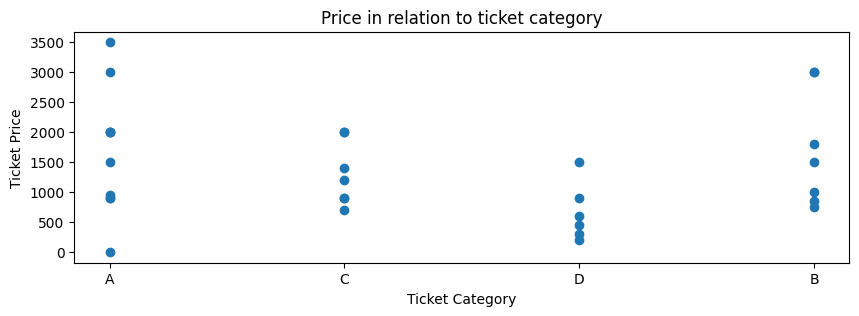

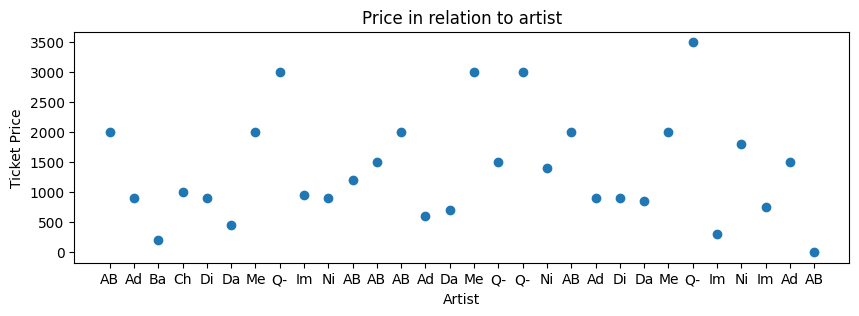

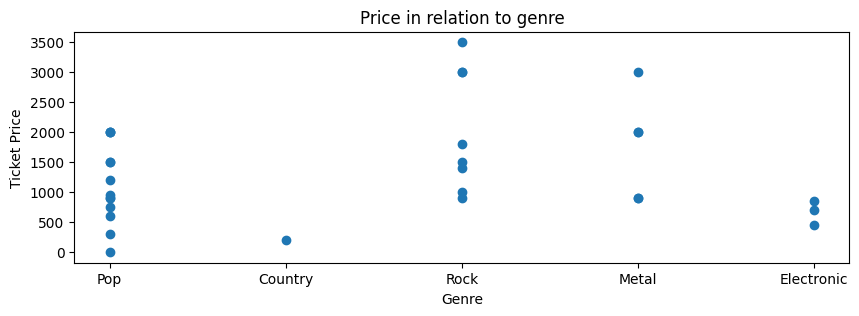

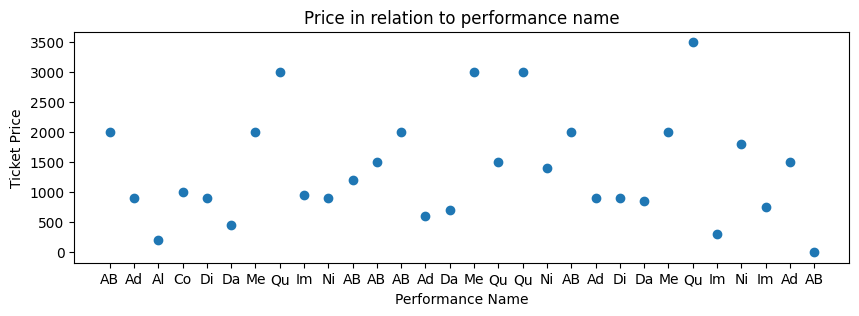

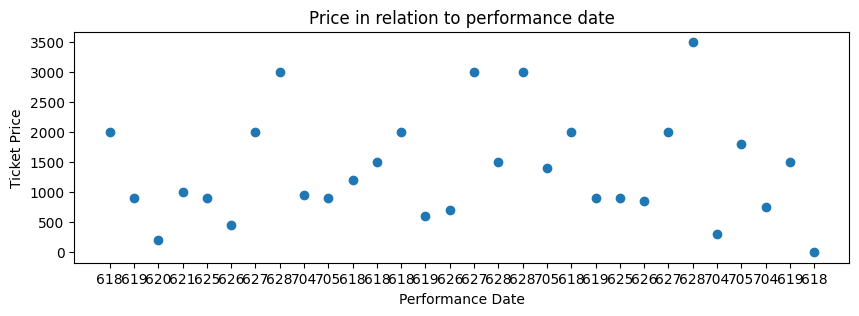

In [72]:
for column in X.columns:
    plt.figure(figsize=(10, 3))
    
    if column in ('Artist', 'Performance Name', 'Performance Date'):
        if column == 'Performance Date':
            short_labels = X[column].str[6:7] + X[column].str[8:10]
        else:
            short_labels = X[column].str[:2]
        
        x_positions = range(len(X[column]))
        
        plt.scatter(x_positions, y)
        plt.xticks(ticks=x_positions, labels=short_labels)
    else:
        plt.scatter(X[column], y)
    
    plt.title(f'Price in relation to {column.lower()}')
    plt.xlabel(f'{column}')
    plt.ylabel('Ticket Price')
    
    plt.show()

### Encode the Performance Date column

Performance Date is represented with the date and time of the performance and looks like $i^{(1)}_{perform. date}$ = 2025-06-18 20:30:00

The date is broken up into 4 parts: (year ignored as examples only contain recent data)
- month
- day
- hour
- minute

Due to the cyclical nature of dates and times, for each of the features two new features are engineered with sin(x) and cos(x) to represent them as a point on a circle. This way, hour 23 is as close to 0 as 0 is to 1


In [73]:
def encode_date(df):
    encd_df = df.copy()
    encd_df['Month'] = df['Performance Date'].str[5:7].astype(int)
    encd_df['Day'] = df['Performance Date'].str[8:10].astype(int)
    encd_df['Hour'] = df['Performance Date'].str[11:13].astype(int)
    encd_df['Minute'] = df['Performance Date'].str[14:16].astype(int)

    date_map = {'Month': 12, 'Day': 30, 'Hour': 24, 'Minute': 60}

    for column, count in date_map.items():
        if column == 'Month' or column == 'Day':
            adjust = 1
        else:
            adjust = 0
        encd_df[f'{column} Sin'] = np.sin((encd_df[column]-adjust) * (2.*np.pi/count))
        encd_df[f'{column} Cos'] = np.cos((encd_df[column]-adjust) * (2.*np.pi/count))

    drop_cols = ['Performance Date', 'Month', 'Day', 'Hour', 'Minute']
    encd_df = encd_df.drop(drop_cols, axis=1)
    return encd_df

### One-hot-encoding for categorical data

- Categorical data is encoded into separate columns with 1s or 0s for each of the unique values it can take - this is known as one-hot-encoding

- In this instance we use sklearn's OneHotEncoder class

In [74]:
# one-hot encoding for ticket category, artist, genre, performance name columns

def one_hot_encode_df(df, cat_cols=['Ticket Category', 
                                'Artist', 'Genre', 
                                'Performance Name']):
    
    one_hot_enc = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ohe_array = one_hot_enc.fit_transform(df[cat_cols])

    ohe_df = pd.DataFrame(
        ohe_array,
        columns=one_hot_enc.get_feature_names_out(cat_cols),
        index=df.index
    )

    encd_df = df.drop(cat_cols, axis=1)
    encd_df = pd.concat([encd_df, ohe_df], axis=1)
    return encd_df

### Encode X and split X and y into datasets for training and testing

In [75]:
X_encoded = one_hot_encode_df(encode_date(X))

In [76]:
X_train = X_encoded.iloc[0:24]
X_test = X_encoded.iloc[24:30]
y_train = y.iloc[0:24]
y_test = y.iloc[24:30]

### Train the model and visualise results on X_test

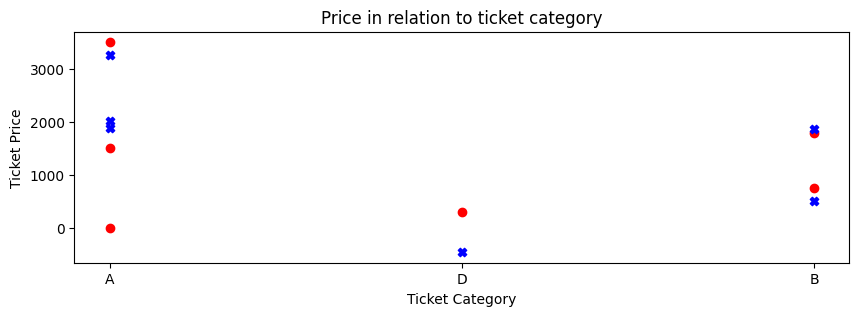

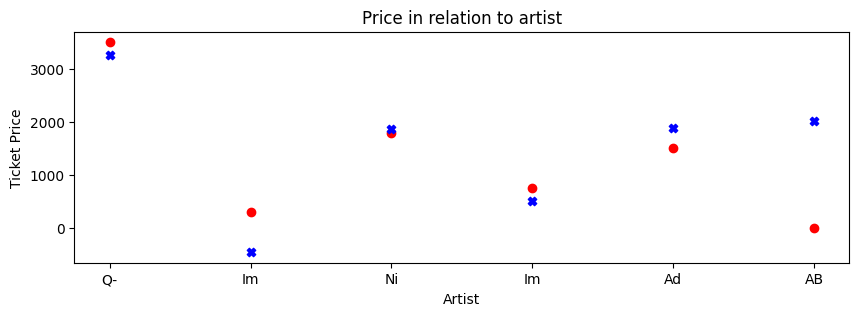

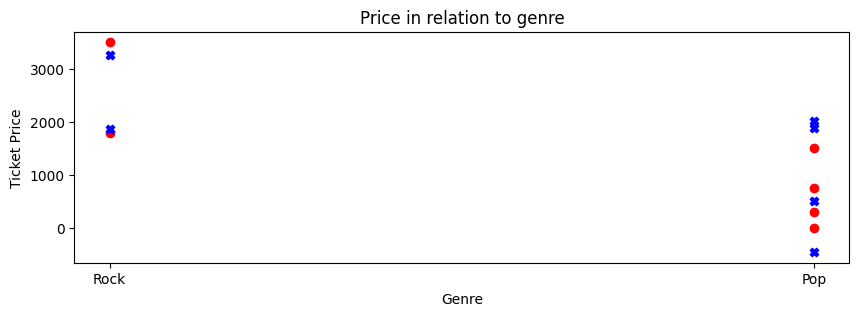

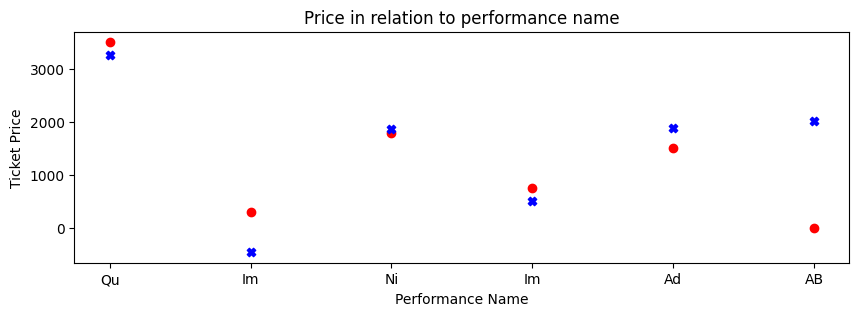

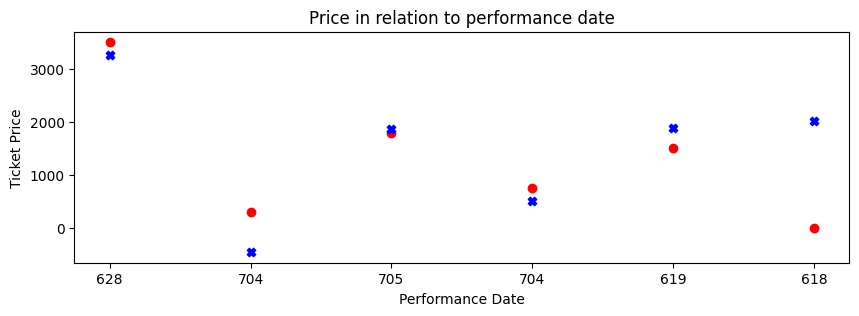

In [77]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
X_test_og = X.iloc[24:30]

for column in X_test_og:
    plt.figure(figsize=(10, 3))
    
    if column in ('Artist', 'Performance Name', 'Performance Date'):
        if column == 'Performance Date':
            short_labels = X_test_og[column].str[6:7] + X_test_og[column].str[8:10]
        else:
            short_labels = X_test_og[column].str[:2]
        
        x_positions = range(len(X_test_og[column]))
        
        plt.scatter(x_positions, y_test, color='red')
        plt.scatter(x_positions, y_pred, color='blue', marker='X')
        plt.xticks(ticks=x_positions, labels=short_labels)
    else:
        plt.scatter(X_test_og[column], y_test, color='red')
        plt.scatter(X_test_og[column], y_pred, color='blue', marker='X')
    
    plt.title(f'Price in relation to {column.lower()}')
    plt.xlabel(f'{column}')
    plt.ylabel('Ticket Price')
    
    plt.show()